In [1]:
"""
notebook designed to compare thickness measurement at picked crossover locations

### psuedocode ###
1. read in pick point dataframe
2. convert points in each track to continuous linestring
3. find all intersection points for all linestrings
4. find closest point in each track at crossing to intersection point for all intersections
5. compare thickness measurements at closes points and build statistics

BST 08OCT2020
python3
"""
### impots ###
import sys, os, itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString


%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 8]

In [10]:
### functions ###
R = 6367000     # earth's radius in meters

def haversinedist_point_array(plon, plat, lonarray, latarray):
    """
    calculate the great circle distance between points on the earth (specified in decimal degrees)
    """
    plon, plat, lonarray, latarray = map(np.radians, [plon, plat, lonarray, latarray])

    dlon = lonarray - plon
    dlat = latarray - plat

    a = np.sin(dlat/2.0)**2 + np.cos(plat) * np.cos(latarray) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    m = R * c
    return m

def track_crossings(lines):
    """ 
    append track names and point to crrossings list for each track intersection
    """
    crossings = []
    for line1,line2 in  itertools.combinations(lines, 2):
        if  line1[1].intersects(line2[1]):
            crossing = line1[1].intersection(line2[1])
            if "Point" == crossing.type:
                crossings.append([line1[0],line2[0],crossing])
            elif "MultiPoint" == crossing.type:
                for pt in crossing:
                    crossings.append([line1[0],line2[0],pt])
            elif "MultiLineString" == crossing.type:
                multiLine = [line for line in crossing]
                first_coords = multiLine[0].coords[0]
                last_coords = multiLine[len(multiLine)-1].coords[1]
                crossings.append([line1[0],Point(first_coords[0], first_coords[1])])
                crossings.append([line2[0],Point(last_coords[0], last_coords[1])])
    return crossings

In [3]:
### params ###
dpath = "/home/btober/Documents/data/radar/malaspina/"
thresh = 100                # distance threshold between crossover points [m]

In [5]:
# now let's try with some malaspin data
df = pd.read_csv(dpath + "malaBed_15_16_18_19_adem2m.csv")
df = df[df["subsrfElev"].notna()]
df.head()

,track,trace,lon,lat,alt,gndElev,srfIdx,srfTwtt,srfAmp,subsrfIdx,subsrfTwtt,subsrfAmp,subsrfElev,thick
103,2015_may14_10,103,-140.438552,59.803015,459.668,156.772156,0.0,0.000004,0.0,0.0,0.000005,0.0,70.566422,86.205734
104,2015_may14_10,104,-140.441008,59.803443,461.771,151.281494,0.0,0.000004,0.0,0.0,0.000005,0.0,61.695143,89.586351
105,2015_may14_10,105,-140.442650,59.803738,462.082,142.160660,0.0,0.000003,0.0,0.0,0.000005,0.0,47.503383,94.657277
106,2015_may14_10,106,-140.445121,59.804195,462.978,150.176193,0.0,0.000003,0.0,0.0,0.000005,0.0,48.757683,101.418511
107,2015_may14_10,107,-140.446767,59.804507,464.501,156.506256,0.0,0.000003,0.0,0.0,0.000005,0.0,48.326511,108.179745


In [7]:
# lets try converting points in each track to it's own linestring then seeing where linestrings intersect

# Zip the coordinates into a point object and convert to a GeoDataFrame
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
gdf = GeoDataFrame(df, geometry=geometry)

# Aggregate these points with the GroupBy
gdf2 = gdf.groupby(["track"])["geometry"].apply(lambda x: LineString(x.tolist()))
gdf2 = GeoDataFrame(gdf2, geometry="geometry")

# compile list of lines with linestring
lines = list(gdf2["geometry"])
lines = [tuple((fname, lines[_i])) for _i, fname in enumerate(gdf2.index.values)]

In [11]:
# get all line crossings
crossings = track_crossings(lines)

In [13]:
# find closest point on both tracks to each intersection
# initialize arrays to hold data
lon = np.array(())
lat = np.array(())
track0 = np.array(())
track1 = np.array(())
thick0 = np.array(())
thick1 = np.array(())

for _i, crossing in enumerate(crossings):
    df_sub0 = df[df["track"]==crossing[0]]
    df_sub1 = df[df["track"]==crossing[1]]
    
    # get closet point for both tracks to crossing - ensure minimum distances are below threshold
    dist0 = haversinedist_point_array(df_sub0["lon"].to_numpy(), df_sub0["lat"].to_numpy(), crossing[2].x, crossing[2].y)
    dist1 = haversinedist_point_array(df_sub1["lon"].to_numpy(), df_sub1["lat"].to_numpy(), crossing[2].x, crossing[2].y)
    if np.min(dist0) < thresh and np.min(dist1) < thresh:
        point0 = np.argmin(dist0)
        point1 = np.argmin(dist1)

        # get thickness measurement
        lon = np.append(lon, crossing[2].x)
        lat = np.append(lat, crossing[2].y)
        track0 = np.append(track0, crossing[0])
        track1 = np.append(track1, crossing[1])
        thick0 = np.append(thick0, df_sub0["thick"].iloc[point0])
        thick1 = np.append(thick1, df_sub1["thick"].iloc[point1])

In [14]:
# build df
crossings_df = pd.DataFrame({"lon":lon, "lat":lat,
                            "track0":track0, "track1": track1,
                            "thick0":thick0, "thick1":thick1,
                            "diff":np.abs(thick1-thick0)})
crossings_df.to_csv(dpath + "malapickstats.csv", index=False)

In [15]:
crossings_df.describe()

,lon,lat,thick0,thick1,diff
count,158.000000,158.000000,158.000000,158.000000,158.000000
mean,-140.592497,59.939775,432.615675,442.370122,54.883260
std,0.199178,0.062086,123.939873,135.593051,48.826026
min,-141.056382,59.774089,89.586351,76.063883,0.194301
25%,-140.734724,59.906057,355.387364,354.332771,20.382577
50%,-140.582443,59.942283,451.312372,455.538143,42.257713
75%,-140.461143,59.980001,532.447180,534.402793,70.682956
max,-140.188579,60.104573,691.336180,772.470989,290.733064


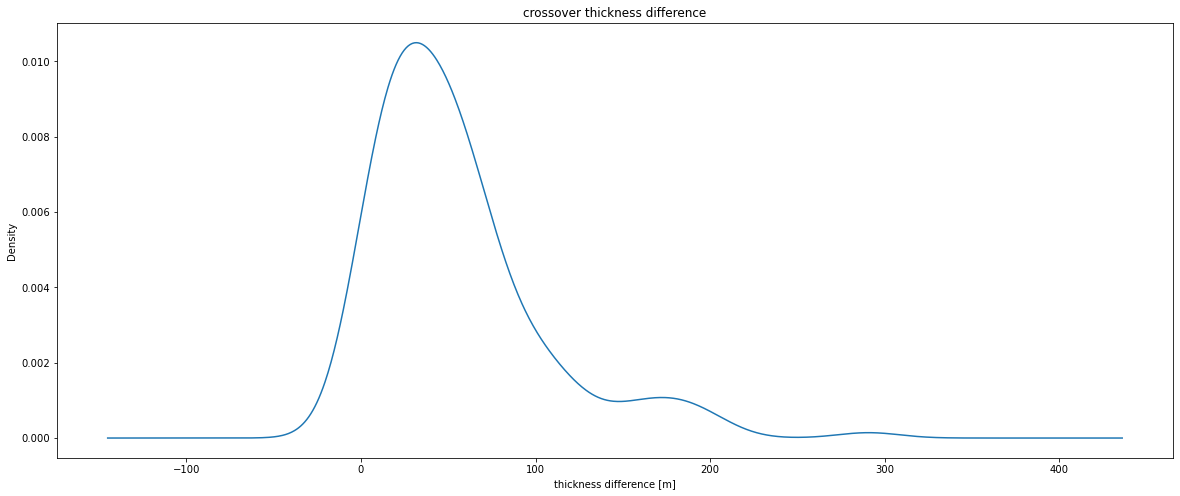

In [16]:
crossings_df["diff"].plot.kde()
plt.xlabel('thickness difference [m]')
plt.title('crossover thickness difference')
plt.show()

In [19]:
crossings_df.sort(["diff"], ascending=[1])

AttributeError: 'DataFrame' object has no attribute 'sort'